# AMEX Default Prediction

## Set up

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
pd.options.display.max_rows = 200
pd.options.display.max_info_columns = 200

## Data Import

### Parquet Data

In [3]:
# load parquet data
train_data = pd.read_parquet('dataset/train.parquet')

### CSV Data

In [8]:
parquet_data = pd.read_parquet('dataset/train.parquet')

In [3]:
train_data = pd.read_csv('dataset/train_data.csv')

In [11]:
train_data["D_63"] = parquet_data["D_63"]

In [14]:
train_data["D_64"] = parquet_data["D_64"]

### Label Data

In [4]:
raw_labels = pd.read_csv('dataset/train_labels.csv')

In [5]:
# fit train_labels to the same number length as train_data
customer_target_dict = dict(zip(raw_labels["customer_ID"], raw_labels["target"]))

In [6]:
train_labels = pd.DataFrame(data=train_data["customer_ID"], columns=["customer_ID"])
train_labels["target"] = train_data["customer_ID"].map(customer_target_dict)

## Data Preprocessing

### Parquet data preprocessing

1. Set nan/-1 value to the mean of their class for each feature
1. Normalize data between 0 and 1

In [7]:
columns = train_data.columns[2:]
pbar = tqdm(range(len(columns)))

for it in pbar: 
    feature = columns[it]
    feature_data = train_data[feature]
    no_nan = feature_data.isnull().sum()
    no_neg_one = (feature_data == -1).sum()

    if no_nan > 0:
        complete_data = feature_data.loc[np.logical_not(feature_data.isnull())]
        complete_labels = train_labels.loc[complete_data.index]
        nan_data = feature_data.loc[feature_data.isnull()]
        nan_labels = train_labels.loc[nan_data.index]
    elif no_neg_one > 0:
        complete_data = feature_data.loc[np.logical_not(feature_data == -1)]
        complete_labels = train_labels.loc[complete_data.index]
        nan_data = feature_data.loc[feature_data == -1]
        nan_labels = train_labels.loc[nan_data.index]
    else:
        # normalize data
        max_value = feature_data.max()
        min_value = feature_data.min()
        train_data[feature] = (train_data[feature] - min_value) / (max_value - min_value)
        continue

    # split complete_data into 2 classes: default and not_default
    default_mask = complete_labels["target"] == 1
    default_indices = complete_labels.loc[default_mask].index
    default_data = complete_data.loc[default_indices]
    mean_default_data = np.average(default_data)

    ndefault_mask = complete_labels["target"] == 0
    ndefault_indices = complete_labels.loc[ndefault_mask].index
    ndefault_data = complete_data.loc[ndefault_indices]
    mean_ndefault_data = np.average(ndefault_data)

    # split nan_data into 2 classes: default and not_default
    default_mask = nan_labels["target"] == 1
    default_indices = nan_labels.loc[default_mask].index
    train_data.loc[default_indices, feature] = mean_default_data

    ndefault_mask = nan_labels["target"] == 0
    ndefault_indices = nan_labels.loc[ndefault_mask].index
    train_data.loc[ndefault_indices, feature] = mean_ndefault_data

    # normalize data
    max_value = train_data[feature].max()
    min_value = train_data[feature].min()
    if (abs(max_value - min_value) > 0):
        train_data[feature] = (train_data[feature] - min_value) / (max_value - min_value)
    
    pbar.set_description('iter %d, feature: %s' % (it, feature))


iter 187, feature: D_145: 100%|██████████| 188/188 [02:12<00:00,  1.42it/s]


### CSV data preprocessing

In [20]:
columns = train_data.columns[2:]
pbar = tqdm(range(len(columns)))

for it in pbar: 
    feature = columns[it]
    feature_data = train_data[feature]
    no_nan = feature_data.isnull().sum()
    no_neg_one = (feature_data == -1).sum()

    if no_nan > 0:
        complete_data = feature_data.loc[np.logical_not(feature_data.isnull())]
        complete_labels = train_labels.loc[complete_data.index]
        nan_data = feature_data.loc[feature_data.isnull()]
        nan_labels = train_labels.loc[nan_data.index]
    elif no_neg_one > 0:
        complete_data = feature_data.loc[np.logical_not(feature_data == -1)]
        complete_labels = train_labels.loc[complete_data.index]
        nan_data = feature_data.loc[feature_data == -1]
        nan_labels = train_labels.loc[nan_data.index]
    else:
        continue

    # split complete_data into 2 classes: default and not_default
    default_mask = complete_labels["target"] == 1
    default_indices = complete_labels.loc[default_mask].index
    default_data = complete_data.loc[default_indices]
    mean_default_data = np.average(default_data)

    ndefault_mask = complete_labels["target"] == 0
    ndefault_indices = complete_labels.loc[ndefault_mask].index
    ndefault_data = complete_data.loc[ndefault_indices]
    mean_ndefault_data = np.average(ndefault_data)

    # split nan_data into 2 classes: default and not_default
    default_mask = nan_labels["target"] == 1
    default_indices = nan_labels.loc[default_mask].index
    train_data.loc[default_indices, feature] = mean_default_data

    ndefault_mask = nan_labels["target"] == 0
    ndefault_indices = nan_labels.loc[ndefault_mask].index
    train_data.loc[ndefault_indices, feature] = mean_ndefault_data
    
    pbar.set_description('iter %d, feature: %s' % (it, feature))


iter 187, feature: D_145: 100%|██████████| 188/188 [01:28<00:00,  2.12it/s]


In [21]:
numerical_data = train_data.iloc[:,2:]

In [30]:
numerical_data.min()

P_2     -4.589548e-01
D_39     5.026190e-09
B_1     -7.588799e+00
B_2      9.192280e-09
R_1      1.534223e-09
S_3     -6.271320e-01
D_41     5.566545e-10
B_3      6.285293e-09
D_42    -4.543303e-04
D_43     1.154550e-07
D_44     5.153088e-10
B_4      3.099332e-09
D_45     1.563241e-08
B_5      2.804822e-11
R_2      8.265748e-10
D_46    -1.728934e+01
D_47    -2.662164e-02
D_48    -9.615277e-03
D_49     5.021298e-07
B_6     -5.178168e-03
B_7     -2.652748e+00
B_8      1.153704e-08
D_50    -3.064871e+02
D_51     3.551498e-10
B_9      6.726070e-09
R_3      2.238322e-09
D_52    -7.083109e-03
P_3     -1.519690e+00
B_10    -2.958481e-03
D_53     5.678129e-08
S_5      8.168135e-09
B_11     2.017814e-08
S_6      2.541465e-09
D_54    -2.005767e-03
R_4      4.024685e-10
S_7     -4.701318e-01
B_12     3.343624e-08
S_8      6.187214e-09
D_55     2.353218e-08
D_56    -1.708915e-02
B_13     1.905850e-08
R_5      1.154589e-09
D_58     4.968945e-09
S_9      2.823498e-07
B_14    -8.469854e+00
D_59    -1

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff3a88f1250>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff3a88f17f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff38a6b5f40>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff3a88f1d90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff389f280a0>],
 'means': []}

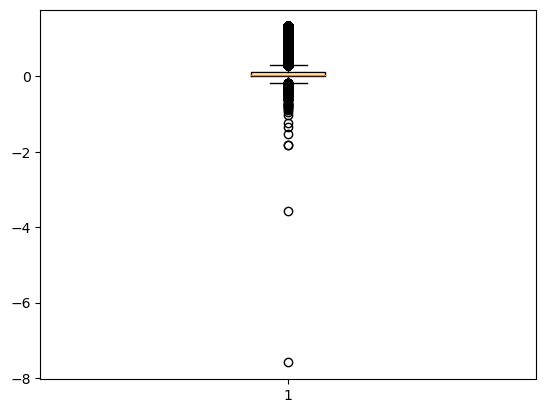

In [31]:
plt.boxplot(numerical_data["B_1"])

## Dimensinality Reduction

In [12]:
from sklearn import decomposition

/Users/emmadang/opt/anaconda3/envs/amex/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
numerical_data = train_data.iloc[:,2:]

In [27]:
pca_model = decomposition.PCA(n_components=0.95)
data_r = pca_model.fit(numerical_data).transform(numerical_data)

In [28]:
pca_model.explained_variance_ratio_

array([0.19782245, 0.1190792 , 0.0822417 , 0.06204117, 0.05784866,
       0.04518067, 0.03350075, 0.03027439, 0.02624651, 0.02360146,
       0.02256212, 0.01966472, 0.0173104 , 0.01620842, 0.01497682,
       0.01455924, 0.01390444, 0.01281307, 0.01219506, 0.01079176,
       0.01073576, 0.00981414, 0.00966208, 0.00870966, 0.00671598,
       0.00612121, 0.00559603, 0.00525137, 0.00501572, 0.004867  ,
       0.00478529, 0.0045892 , 0.00427876, 0.00427128, 0.00400355,
       0.00391649, 0.00379034, 0.00366845, 0.00347657, 0.00314388,
       0.00308639, 0.00301548])

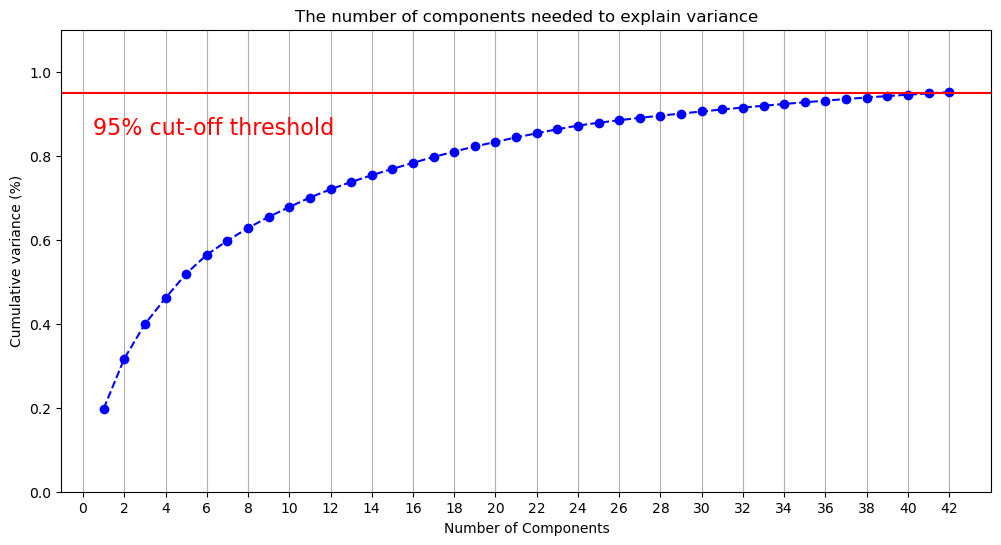

In [29]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 43, step=1)
y = np.cumsum(pca_model.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 43, step=2)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

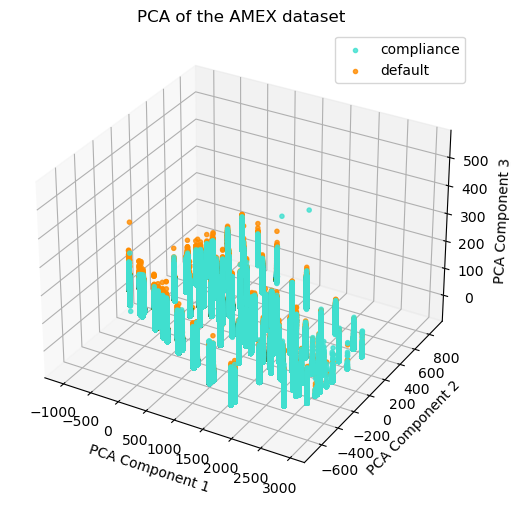

In [44]:
target_names = ["compliance", "default"]
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
colors = ["turquoise", "darkorange"]

for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.scatter(
        data_r[train_labels["target"]==i, 0], data_r[train_labels["target"]==i, 1], data_r[train_labels["target"]==i, 2], s=9, alpha=0.8 ,color=color, label=target_name
    )

ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.legend(loc="best", shadow=False, scatterpoints=1)

plt.title("PCA of the AMEX dataset")
plt.show()

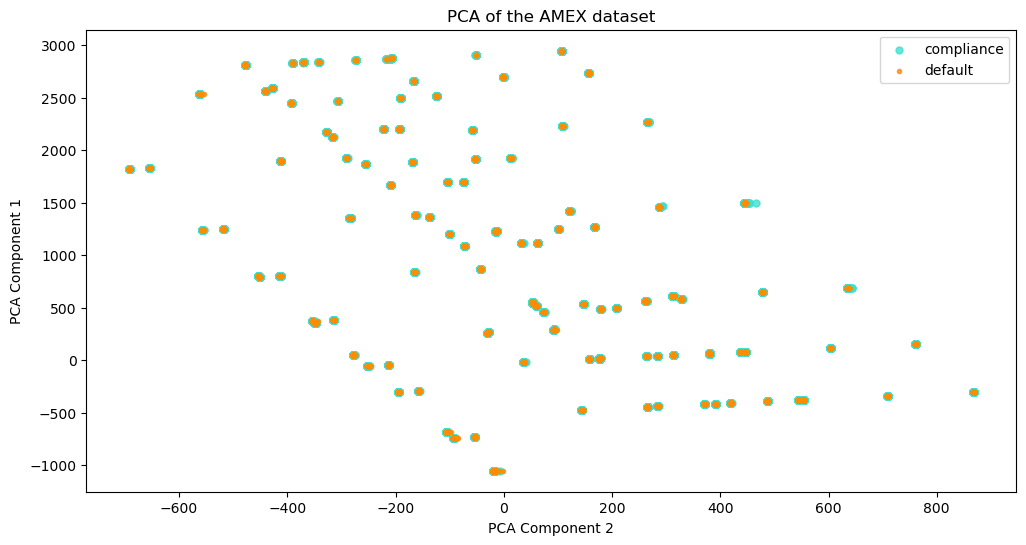

In [49]:
target_names = ["compliance", "default"]
fig = plt.figure()
colors = ["turquoise", "darkorange"]
marker_sizes = [25, 9]

for color, i, ms, target_name in zip(colors, [0, 1], marker_sizes, target_names):
    plt.scatter(
        data_r[train_labels["target"]==i, 1], data_r[train_labels["target"]==i, 0], s=ms, alpha=0.8 ,color=color, label=target_name
    )

plt.xlabel("PCA Component 2")
plt.ylabel("PCA Component 1")
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of the AMEX dataset")
plt.show()